## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [2]:
# Define the path of the PDF
single_pdf_path = 'D:\ML\data\policy\Principal-Sample-Life-Insurance-Policy.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [3]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

#### <font color = red> 2.2 Extracting text from the PDF

Let's now try and extract text from the pdf using appropriate preprocessing, and store them in a dataframe


In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for the PDFs in our drive and store them in a list.*

In [10]:
# Define the directory containing the PDF files
pdf_path = single_pdf_path

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a DF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
extracted_text_df['Document Name'] = pdf_path

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing D:\ML\data\policy\Principal-Sample-Life-Insurance-Policy.pdf
Finished processing D:\ML\data\policy\Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [11]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [12]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,D:\ML\data\policy\Principal-Sample-Life-Insura...
1,Page 2,This page left blank intentionally,D:\ML\data\policy\Principal-Sample-Life-Insura...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,D:\ML\data\policy\Principal-Sample-Life-Insura...
3,Page 4,This page left blank intentionally,D:\ML\data\policy\Principal-Sample-Life-Insura...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,D:\ML\data\policy\Principal-Sample-Life-Insura...
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,D:\ML\data\policy\Principal-Sample-Life-Insura...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,D:\ML\data\policy\Principal-Sample-Life-Insura...
61,Page 62,A claimant may request an appeal of a claim de...,D:\ML\data\policy\Principal-Sample-Life-Insura...
62,Page 63,This page left blank intentionally,D:\ML\data\policy\Principal-Sample-Life-Insura...


In [13]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [14]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [15]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [16]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,D:\ML\data\policy\Principal-Sample-Life-Insura...,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,D:\ML\data\policy\Principal-Sample-Life-Insura...,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,D:\ML\data\policy\Principal-Sample-Life-Insura...,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,D:\ML\data\policy\Principal-Sample-Life-Insura...,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,387
9,Page 10,T he legally recognized union of two eligible ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,251
10,Page 11,(2) has been placed with the Member or spouse ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,299
11,Page 12,An institution that is licensed as a Hospital ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,352


In [17]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

C:\Users\anila\AppData\Local\Temp\ipykernel_13280\1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [18]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,D:\ML\data\policy\Principal-Sample-Life-Insura...,30,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,D:\ML\data\policy\Principal-Sample-Life-Insura...,230,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,D:\ML\data\policy\Principal-Sample-Life-Insura...,110,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,D:\ML\data\policy\Principal-Sample-Life-Insura...,153,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
6,Page 7,Section A – Eligibility Member Life Insurance ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,176,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
7,Page 8,Section A - Member Life Insurance Schedule of ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,171,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,387,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
9,Page 10,T he legally recognized union of two eligible ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,251,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
10,Page 11,(2) has been placed with the Member or spouse ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,299,{'Policy_Name': 'D:\ML\data\policy\Principal-S...
11,Page 12,An institution that is licensed as a Hospital ...,D:\ML\data\policy\Principal-Sample-Life-Insura...,352,{'Policy_Name': 'D:\ML\data\policy\Principal-S...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [19]:
# Set the API key
filepath = "D:\\ML\\code\\"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [20]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [45]:
# Define the path where chroma collections will be stored

chroma_data_path = 'D:\ML\data\ChromaDB_HelpMate_Data'

In [46]:
import chromadb

In [48]:
from chromadb.config import Settings

# Initialize ChromaDB client with persistent storage settings
client = chromadb.Client(Settings(persist_directory=chroma_data_path))

In [49]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [51]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [52]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [53]:
# Add the documents and metadata to the collection alongwith generic integer IDs. 
# You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [54]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.23971158e-02,  1.87055711e-02, -2.72365622e-02, ...,
         -3.68371904e-02,  2.83061969e-03, -1.33541331e-03],
        [-1.31341917e-02,  8.94140638e-03, -4.64911945e-03, ...,
         -1.56731941e-02, -8.43698308e-06,  7.23958854e-03],
        [-1.20889228e-02,  1.42253852e-02, -3.48999654e-03, ...,
         -2.87161693e-02, -9.76668205e-03,  1.03770997e-02]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [55]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [56]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [118]:
# Read the user query

query1 = (
'What are the conditions under which Actively at Work requirements can be Waived. Extract out information about Waived members'
)

In [149]:
query2 = (
'What are the conditions under which a Member or Dependent who is outside of the United States will continue to get coverage?'
)

In [167]:
query3 = (
'What are the Covered Loss and Schedule of Benefits under Loss of Use or Paralysis?'
)

In [168]:
#change queries here...
query = query3

In [169]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [170]:
cache_results

{'ids': [['What are the conditions under which a Member or Dependent who is outside of the United States will continue to get coverage?']],
 'embeddings': None,
 'documents': [['What are the conditions under which a Member or Dependent who is outside of the United States will continue to get coverage?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '0.2262953817844391',
    'distances1': '0.23984158039093018',
    'distances2': '0.2885672450065613',
    'distances3': '0.2986432909965515',
    'distances4': '0.3305676579475403',
    'distances5': '0.33208346366882324',
    'distances6': '0.33794453740119934',
    'distances7': '0.345994770526886',
    'distances8': '0.348627507686615',
    'distances9': '0.35598137974739075',
    'documents0': 'I f coverage for a Member or Dependent terminates because the person is outside of the United States as discussed in PART III, Section C, Article 5, the Member or Dependent may become eligible again for coverage under this Group 

In [171]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['53', '5', '54', '51', '52', '50', '43', '56', '46', '29']]), ('embeddings', None), ('documents', [['If a Member sustains an injury, and as a result of such injury, one or more of the covered losses listed below are incurred, The Principal will pay the following percentages of the Member\'s Scheduled Benefit (or approved amount, if applicable) in force, provided all Benefit Qualifications as described in Article 2 are met. % of Scheduled Covered Loss Benefit Loss of Use or Paralysis Quadriplegia 100% Paraplegia 50% Hemiplegia 50% Both Hands or Both Feet 50% One Hand and One Foot 50% One Arm or One Leg 25% One Hand or One Foot 25% The Principal does not pay an Accidental Death and Dismemberment benefit for any paralysis caused by a stroke. Paralysis must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). P

In [172]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          if i < len(val[0]):
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [173]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 56', 'Policy_Name': 'D:\ML\...","If a Member sustains an injury, and as a resul...",0.200164,53
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'D:\ML\d...",Section A - Member Life Insurance Schedule of ...,0.275592,5
2,"{'Page_No.': 'Page 57', 'Policy_Name': 'D:\ML\...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.291619,54
3,"{'Page_No.': 'Page 54', 'Policy_Name': 'D:\ML\...","f . claim requirements listed in PART IV, Sect...",0.296064,51
4,"{'Page_No.': 'Page 55', 'Policy_Name': 'D:\ML\...",Exposure Exposure to the elements will be pres...,0.302583,52
5,"{'Page_No.': 'Page 53', 'Policy_Name': 'D:\ML\...",Section B - Member Accidental Death and Dismem...,0.308158,50
6,"{'Page_No.': 'Page 46', 'Policy_Name': 'D:\ML\...",PART IV - BENEFITS Section A - Member Life Ins...,0.339419,43
7,"{'Page_No.': 'Page 59', 'Policy_Name': 'D:\ML\...",Section C - Dependent Life Insurance Article 1...,0.344697,56
8,"{'Page_No.': 'Page 49', 'Policy_Name': 'D:\ML\...",Payment of benefits will be subject to the Ben...,0.346427,46
9,"{'Page_No.': 'Page 32', 'Policy_Name': 'D:\ML\...",(1) marriage or establishment of a Civil Union...,0.347003,29


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

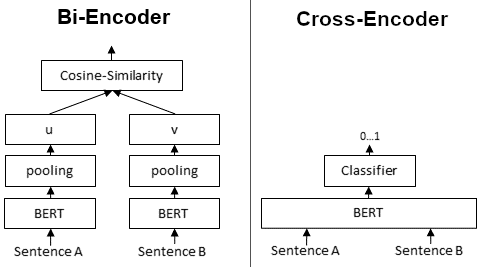

<br>

In [174]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [175]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [176]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [177]:
scores

array([  3.8467631, -11.252879 ], dtype=float32)

In [178]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [179]:
cross_rerank_scores

array([ 4.9366207 ,  1.1858987 , -0.23220769, -3.9522362 , -1.9668746 ,
       -5.3901386 , -8.202724  , -8.176485  , -8.467831  , -7.990136  ],
      dtype=float32)

In [180]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [181]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 56', 'Policy_Name': 'D:\ML\...","If a Member sustains an injury, and as a resul...",0.200164,53,4.936621
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'D:\ML\d...",Section A - Member Life Insurance Schedule of ...,0.275592,5,1.185899
2,"{'Page_No.': 'Page 57', 'Policy_Name': 'D:\ML\...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.291619,54,-0.232208
3,"{'Page_No.': 'Page 54', 'Policy_Name': 'D:\ML\...","f . claim requirements listed in PART IV, Sect...",0.296064,51,-3.952236
4,"{'Page_No.': 'Page 55', 'Policy_Name': 'D:\ML\...",Exposure Exposure to the elements will be pres...,0.302583,52,-1.966875
5,"{'Page_No.': 'Page 53', 'Policy_Name': 'D:\ML\...",Section B - Member Accidental Death and Dismem...,0.308158,50,-5.390139
6,"{'Page_No.': 'Page 46', 'Policy_Name': 'D:\ML\...",PART IV - BENEFITS Section A - Member Life Ins...,0.339419,43,-8.202724
7,"{'Page_No.': 'Page 59', 'Policy_Name': 'D:\ML\...",Section C - Dependent Life Insurance Article 1...,0.344697,56,-8.176485
8,"{'Page_No.': 'Page 49', 'Policy_Name': 'D:\ML\...",Payment of benefits will be subject to the Ben...,0.346427,46,-8.467831
9,"{'Page_No.': 'Page 32', 'Policy_Name': 'D:\ML\...",(1) marriage or establishment of a Civil Union...,0.347003,29,-7.990136


In [182]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 56', 'Policy_Name': 'D:\ML\...","If a Member sustains an injury, and as a resul...",0.200164,53,4.936621
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'D:\ML\d...",Section A - Member Life Insurance Schedule of ...,0.275592,5,1.185899
2,"{'Page_No.': 'Page 57', 'Policy_Name': 'D:\ML\...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.291619,54,-0.232208


In [183]:
# Print the Query and the Top 3 Results from the Search Layer
print("Query: " + query)
print("\n"+ "Top 3 Results from the Search Layer:-")
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

Query: What are the Covered Loss and Schedule of Benefits under Loss of Use or Paralysis?

Top 3 Results from the Search Layer:-


,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 56', 'Policy_Name': 'D:\ML\...","If a Member sustains an injury, and as a resul...",0.200164,53,4.936621
1,"{'Page_No.': 'Page 8', 'Policy_Name': 'D:\ML\d...",Section A - Member Life Insurance Schedule of ...,0.275592,5,1.185899
2,"{'Page_No.': 'Page 57', 'Policy_Name': 'D:\ML\...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.291619,54,-0.232208


In [184]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [185]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [186]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [187]:
# Print the Query and the Final Generated Answer from the Generation Layer
print("Query: " + query)
print("\n"+ "Final Generated Answer from the Generation Layer:-")
print("\n".join(response))

Query: What are the Covered Loss and Schedule of Benefits under Loss of Use or Paralysis?

Final Generated Answer from the Generation Layer:-
The Covered Loss and Schedule of Benefits under Loss of Use or Paralysis are detailed below:

| Covered Loss          | Schedule of Benefits |
|-----------------------|----------------------|
| Paralysis             | 100% of Scheduled Covered Loss Benefit |

**Policy Citations:**  
1. Policy Name: D:\ML\... (Policy document name)  
   Page Number: Page 57

This information is based on the provided insurance document excerpts. For more detailed information and specific terms related to Loss of Use or Paralysis coverage, please refer to the policy document cited above on Page 57.
